In [2]:
import os
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from pointnav_vo.config.vo_config.default import get_config as get_vo_config
from pointnav_vo.vo import VODDPRegressionGeometricInvarianceEngine

ACTIONS = {0: "STOP", 1: "MOVE_FORWARD", 2: "TURN_LEFT", 3: "TURN_RIGHT"}

## extract statistics from dataset

In [3]:
config = get_vo_config('/datasets/home/memmel/PointNav-VO/configs/vo/debug_dataset_visualization.yaml', [])
config.defrost()
config.VO.DATASET.TRAIN_WITH_NOISE = '/scratch/memmel/dataset/train_250000.h5' # /scratch/memmel/dataset/train_100000_23.h5
# config.VO.DATASET.TRAIN_WITH_NOISE = '/scratch/memmel/dataset/val_25000.h5' # /scratch/memmel/dataset/train_100000_23.h5
config.VO.DATASET.TRAIN = config.VO.DATASET.TRAIN_WITH_NOISE
config.VO.DATASET.EVAL = config.VO.DATASET.EVAL_WITH_NOISE

# set collision and invariance settings
config.VO.TRAIN.collision = '0' # -1 w/ collision
config.VO.GEOMETRY.invariance_types = [] # ["inverse_joint_train"]
config.freeze()

# select what to extract
with_mean_std = False

In [4]:
engine = VODDPRegressionGeometricInvarianceEngine(config=config, run_type='train')
engine._set_up_dataloader(0,1)

2022-05-03 07:39:05,112 Visual Odometry configs:
BASE_TASK_CONFIG_PATH: configs/point_nav_habitat_challenge_2020.yaml
CHECKPOINT_FOLDER: {{LOG_DIR}}/checkpoints
DEBUG: False
ENGINE_NAME: vo_ddp_regression_geo_invariance_engine
EVAL:
  EVAL_CKPT_PATH: eval_ckpt.pth
  EVAL_WITH_CKPT: True
INFO_DIR: {{LOG_DIR}}/infos
LOG_DIR: train_log/final/vit/unique/
LOG_FILE: {{LOG_DIR}}/train.log
LOG_INTERVAL: 1
N_GPUS: -1
RESUME_STATE_FILE: auto
RESUME_STATE_PATH: 
RESUME_TRAIN: False
TASK_CONFIG:
  DATASET:
    CONTENT_SCENES: ['*']
    DATA_PATH: dataset/habitat_datasets/pointnav/gibson/v2/{split}/{split}.json.gz
    SCENES_DIR: dataset/Gibson
    SPLIT: train
    TYPE: PointNav-v1
  ENVIRONMENT:
    ITERATOR_OPTIONS:
      CYCLE: True
      GROUP_BY_SCENE: True
      MAX_SCENE_REPEAT_EPISODES: -1
      MAX_SCENE_REPEAT_STEPS: 10000
      NUM_EPISODE_SAMPLE: -1
      SHUFFLE: True
      STEP_REPETITION_RANGE: 0.2
    MAX_EPISODE_SECONDS: 10000000
    MAX_EPISODE_STEPS: 500
  PYROBOT:
    BASE_CONT

In [5]:
data = dict({
    'actions': [],
    'delta_xs': [],
    'delta_ys': [],
    'delta_zs': [],
    'delta_yaws': [],
    'dz_regress_masks': [],
    })
mean, std = torch.zeros(3), torch.zeros(3)
ctr = 0
samples = 0

train_iter = iter(engine.train_loader)
with tqdm(total=0) as pbar:
            
    while True:
        try:
            batch_data = next(train_iter)
        # NOTE RuntimeError: DataLoader timed out after 300 seconds
        except RuntimeError  as re:
            print(re)
            batch_data = next(train_iter)
        except StopIteration:
            break

        (data_types,
        raw_rgb_pairs,
        raw_depth_pairs,
        raw_discretized_depth_pairs,
        raw_top_down_view_pairs,

        actions,
        delta_xs,
        delta_ys,
        delta_zs,
        delta_yaws,
        dz_regress_masks,

        chunk_idxs,
        entry_idxs,
        ) = batch_data
       
        data['actions'].append(actions)
        data['delta_xs'].append(delta_xs)
        data['delta_ys'].append(delta_ys)
        data['delta_zs'].append(delta_zs)
        data['delta_yaws'].append(delta_yaws)
        data['dz_regress_masks'].append(dz_regress_masks)
        
        if with_mean_std:
            rgb = torch.cat([torch.cat((pair[:,:,:,:pair.shape[-1]//2], pair[:,:,:,pair.shape[-1]//2:]),dim=0).float().to(torch.device('cpu'), non_blocking=True)
                            for pair in raw_rgb_pairs], dim=0,)

            mean += (torch.mean(rgb, axis=(0,1,2)) / 255.)
            std += (torch.std(rgb, axis=(0,1,2)) / 255.)
            ctr += 1
            samples += rgb.shape[0]
            
        pbar.update(1)
        break
for k in data.keys():
    data[k] = torch.cat(data[k])


1it [00:10, 10.57s/it]


## extract images based on actions

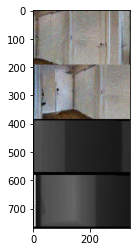

In [95]:
act = 3

rgb = torch.cat([torch.cat((pair[:,:,:,:pair.shape[-1]//2], pair[:,:,:,pair.shape[-1]//2:]),dim=0).float().to(torch.device('cpu'), non_blocking=True)
                            for i,pair in enumerate(raw_rgb_pairs) if i in (actions==act).nonzero()[:,0]], dim=0,)
depth = torch.cat([torch.cat((pair[:,:,:,:pair.shape[-1]//2], pair[:,:,:,pair.shape[-1]//2:]),dim=0).float().to(torch.device('cpu'), non_blocking=True)
                            for i,pair in enumerate(raw_depth_pairs) if i in (actions==act).nonzero()[:,0]], dim=0,)
depth = depth.expand(-1,-1,-1,3)

i = 150 #  must be even
rgb_cat = torch.cat((rgb[i],rgb[i+1]),dim=0)
depth_cat = torch.cat((depth[i],depth[i+1]),dim=0) * 255
both_cat = (torch.cat((rgb_cat,depth_cat),dim=0)).int()
plt.imshow(both_cat)
plt.imsave('right.png', np.uint8(both_cat.numpy()))

## plot statistics

In [ ]:
data_tmp = data.copy()

In [65]:
data_tmp['actions'].unique(), data_tmp['actions'].shape

NameError: name 'data_tmp' is not defined

In [66]:
for unique in data_tmp['actions'].unique():
    print(unique, sum(data_tmp['actions']==unique))

NameError: name 'data_tmp' is not defined

In [67]:
outpath = './plots'
os.makedirs(outpath,exist_ok=True)
fname_append = f"{'_collision' if config.VO.TRAIN.collision == '-1' else ''}{'_invjoint' if 'inverse_joint_train' in config.VO.GEOMETRY.invariance_types else ''}"

In [68]:
with open(os.path.join(outpath,'statistics'+fname_append+'.txt'), 'w') as f:
    f.write(f'mean {(mean / ctr).tolist()}\n')
    f.write(f'std {(std / ctr).tolist()}\n')
    f.write(f'samples ALL {int(samples)}\n')
    for act in ACTIONS:
        f.write(f'samples {ACTIONS[act]} {(data_tmp["actions"]==act).sum()}\n')  

NameError: name 'data_tmp' is not defined

In [ ]:
### plot setup ###
plt.rcParams["figure.figsize"] = (16,4)
fig, axs = plt.subplots(1,4)

### barplot ###
barlist = axs[0].bar(x=[0,1,2], height=[(data_tmp['actions']==act).sum() for act in data_tmp['actions'].unique()])

barlist[0].set_color('tab:blue')
barlist[0].set_label(r'$\mathrm{move\_forward}$')

barlist[1].set_color('tab:green')
barlist[1].set_label(r'$\mathrm{turn\_left}$')

barlist[2].set_color('tab:orange')
barlist[2].set_label(r'$\mathrm{turn\_right}$')

axs[0].set_xticks([])
axs[0].set_ylabel(r'$\mathrm{count}$', fontsize=20)
axs[0].set_ylim([0, 150000])
axs[0].legend()

### scatter plots ###
label_dict = dict({
    'delta_xs': r'$\xi^x_{C_t\rightarrow C_{t+1}}$',
    'delta_zs': r'$\xi^z_{C_t\rightarrow C_{t+1}}$',
    'delta_yaws': r'$\beta_{C_t\rightarrow C_{t+1}}$',
})

plots = [('delta_xs', 'delta_zs'), ('delta_xs', 'delta_yaws'), ('delta_zs', 'delta_yaws')]

for i, (kx,ky) in enumerate(plots):
    for act in data_tmp['actions'].unique():
        selector = data_tmp['actions']==act
        axs[i+1].scatter(data_tmp[kx][selector],
                    data_tmp[ky][selector],
                    label=ACTIONS[act.item()], s=2)

    axs[i+1].set_xlabel(label_dict[kx], fontsize=20)
    axs[i+1].set_ylabel(label_dict[ky], fontsize=20)

    axs[i+1].tick_params(labelsize=10)

### save plot ###
plt.tight_layout()
outfile = os.path.join(outpath,'data_joint'+fname_append+'.png')
plt.savefig(outfile, dpi=300)
outfile